In [14]:
import re
import nltk
import numpy as np
import pandas as pd
from keras.layers import *
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from keras.utils import to_categorical
from nltk.tokenize import word_tokenize
from keras.models import Sequential,Model
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense,Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, load_model
from sklearn.preprocessing import OneHotEncoder
from nltk.stem.lancaster import LancasterStemmer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, GRU, LSTM, Bidirectional, Embedding, Dropout

In [15]:
df=pd.read_excel('/content/Own_Amazon_AddedRows(Final).xlsx')
df.head()
anger_count = len(df[df['emotion'] == 'Angry'])
fear_count = len(df[df['emotion'] == 'Disgusted'])
joy_count = len(df[df['emotion'] == 'Happy'])
sadness_count = len(df[df['emotion'] == 'Sad'])

print("Number of rows with sentiment 'Angry':", anger_count)

print("Number of rows with sentiment 'Disgusted':", fear_count)

print("Number of rows with sentiment 'Happy':", joy_count)

print("Number of rows with sentiment 'Sad':", sadness_count)

Number of rows with sentiment 'Angry': 3902
Number of rows with sentiment 'Disgusted': 4580
Number of rows with sentiment 'Happy': 4661
Number of rows with sentiment 'Sad': 3042


In [16]:
Sentences = df['review'].astype(str)
Sentiments = df['emotion'].astype(str)

In [17]:
glove ='glove.6B.50d.txt'

def load_glove_embeddings(path):
    embeddings_index = {}
    with open(path, 'r', encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

Glove = load_glove_embeddings(glove)

In [18]:
def cosine_similarity(a, b):
    """
    Computes the cosine similarity between two vectors a and b.
    """
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [19]:
import tensorflow as tf

def preprocess(Sentences):
    sentences = tf.strings.substr(Sentences, 0, 300)
    sentences = tf.strings.regex_replace(sentences, b"<br\\s*/?>", b" ")
    sentences = tf.strings.regex_replace(sentences, b"[^a-zA-Z']", b" ")
    sentences = tf.strings.split(sentences)
    sentences = tf.strings.lower(sentences)
    sentences = sentences.to_tensor(default_value=b"<pad>")
    return sentences

In [20]:
sentences = preprocess(Sentences)
sentences.shape

TensorShape([16185, 72])

In [21]:
def encoding(sentences, Glove):
    Encoded_vec = []
    for sentence in sentences:
        sent_vec = []
        for token in sentence:
            token = token.numpy().decode('utf-8')
            if token in Glove:
                sent_vec.append(Glove[token])
            else:
                sent_vec.append(np.zeros(50))
        Encoded_vec.append(sent_vec)
    return Encoded_vec

In [22]:
Encoded_vec = encoding(sentences, Glove)
X = np.array(Encoded_vec)
print(X.shape)

(16185, 72, 50)


In [23]:
enc = OneHotEncoder(handle_unknown='ignore')
Y = enc.fit_transform(np.array(Sentiments).reshape(-1,1)).toarray()
print(Y.shape)

(16185, 4)


In [24]:
from keras.layers import Embedding
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=23)

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense

# Defining the BiLSTM Model
class BiLSTMModel:
    def __init__(self):
        self.model = Sequential()
        self.model.add(Bidirectional(LSTM(150, input_shape=(100, 50))))  # Increase units in LSTM
        self.model.add(Dropout(0.5))  # Increase dropout
        self.model.add(Dense(4, activation='softmax'))
        self.model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

    def fit(self, X_train, Y_train, X_val, Y_val, epochs, batch_size):
        history = self.model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, Y_val))
        return history  # Return the training history for later visualization

    def evaluate(self, X, Y, batch_size):
        return self.model.evaluate(X, Y, batch_size=batch_size)

    def predict(self, X):
        return self.model.predict(X)

In [41]:
# create an instance of the BiLSTMModel class
model = BiLSTMModel()

hist = model.fit(X_train, Y_train, X_test, Y_test,
                 epochs=20,
                 batch_size=64)
# Saved model for Decreased emotions count.
model.model.save('(balanced)20epochs_Own_Amazon.h5')

Epoch 1/20
203/203 [==============================] - 67s 305ms/step - loss: 1.0990 - accuracy: 0.5325 - val_loss: 1.0078 - val_accuracy: 0.5644
Epoch 2/20
203/203 [==============================] - 61s 302ms/step - loss: 0.9705 - accuracy: 0.5879 - val_loss: 0.9524 - val_accuracy: 0.5888
Epoch 3/20
203/203 [==============================] - 58s 285ms/step - loss: 0.9189 - accuracy: 0.6040 - val_loss: 0.9267 - val_accuracy: 0.5981
Epoch 4/20
203/203 [==============================] - 65s 321ms/step - loss: 0.8795 - accuracy: 0.6257 - val_loss: 0.9155 - val_accuracy: 0.6114
Epoch 5/20
203/203 [==============================] - 63s 309ms/step - loss: 0.8540 - accuracy: 0.6382 - val_loss: 0.8867 - val_accuracy: 0.6138
Epoch 6/20
203/203 [==============================] - 59s 292ms/step - loss: 0.8291 - accuracy: 0.6480 - val_loss: 0.8890 - val_accuracy: 0.6101
Epoch 7/20
203/203 [==============================] - 58s 285ms/step - loss: 0.8106 - accuracy: 0.6549 - val_loss: 0.8724 - val_ac

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [42]:
Loss, acc = model.evaluate(X_test, Y_test, batch_size=64)
print("Loss: %.2f" % (Loss))
print("Accuracy: %.2f" % (acc))

51/51 [==============================] - 5s 100ms/step - loss: 0.9806 - accuracy: 0.6281
Loss: 0.98
Accuracy: 0.63


In [43]:
model.model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_20 (Bidirect  (None, 300)               241200    
 ional)                                                          
                                                                 
 dropout_22 (Dropout)        (None, 300)               0         
                                                                 
 dense_10 (Dense)            (None, 4)                 1204      
                                                                 
Total params: 242404 (946.89 KB)
Trainable params: 242404 (946.89 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


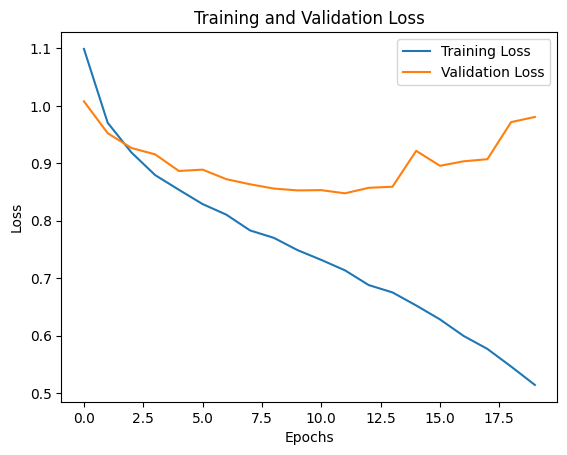

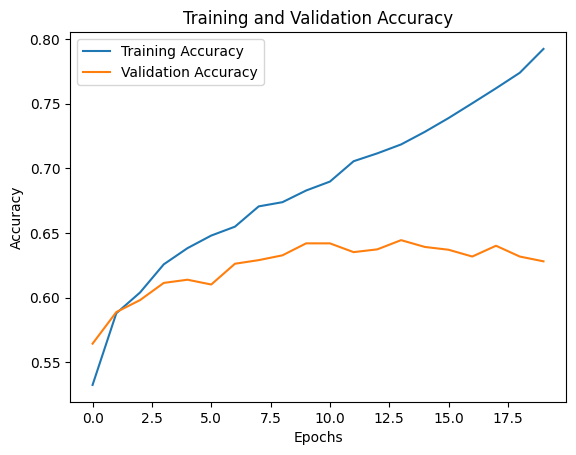

102/102 [==============================] - 14s 124ms/step


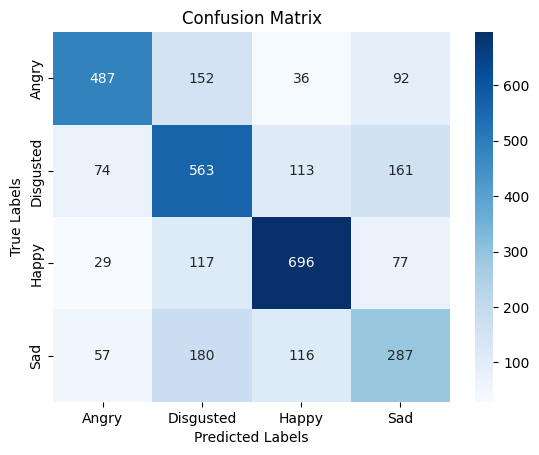

In [44]:
import matplotlib.pyplot as plt
history=hist

# Assuming history contains the training history
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Now you can also generate a confusion matrix using the test data
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predictions on the test data
Y_pred = model.predict(X_test)

# Convert predictions and true labels back from one-hot encoding
Y_pred_labels = np.argmax(Y_pred, axis=1)
Y_true_labels = np.argmax(Y_test, axis=1)

# Create confusion matrix
conf_matrix = confusion_matrix(Y_true_labels, Y_pred_labels)

# Visualize the confusion matrix using seaborn
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=enc.categories_[0], yticklabels=enc.categories_[0])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

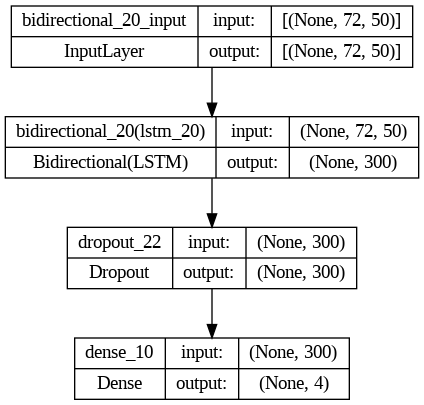

In [47]:
from tensorflow.keras.utils import plot_model
plot_model(model.model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [52]:
while True:

  i=input("Enter : ")
  twt = [i]
  #Next, tokenize it.
  Twt = preprocess(twt)

  # Encoding
  Twt = encoding(Twt, Glove)
  Twt = np.array(Twt)
  print(Twt.shape)
  #Predict the sentiment by passing the sentence to the model we built.
  sentiment = model.predict(Twt)[0]
  label = np.argmax(sentiment)
  print(enc.categories_[0][label])

Enter : Everything is fine and it works perfectly for me
(1, 9, 50)
1/1 [==============================] - 2s 2s/step
Happy
Enter : One of the screens was cracked,never got a response
(1, 10, 50)
1/1 [==============================] - 0s 24ms/step
Disgusted
Enter : It just doesn't make a big deal so it doesn't work
(1, 11, 50)
1/1 [==============================] - 0s 24ms/step
Sad
Enter : This screen protector is perfect. I ran the hot water in the bathroom to get it a little steamy to reduce dust in the air. I placed the guide on my phone, used the dust stickers to get every last speck of dust removed from my screen, pulled the protector from the styrofoam, removed the film, and quickly set it on my phone. Absolutely perfect. The guide is awesome. No dust and there was just one small bubble that I had to press out. I gently pressed the edges down and I could not be more satisfied. THANK YOU!
(1, 58, 50)
1/1 [==============================] - 0s 59ms/step
Happy
Enter : Man this thing 

ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None

    ValueError: Exception encountered when calling layer 'sequential_10' (type Sequential).
    
    Cannot iterate over a shape with unknown rank.
    
    Call arguments received by layer 'sequential_10' (type Sequential):
      • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
      • training=False
      • mask=None
